Projeto Transfer Learning \
Descidi fazer meu próprio dataset com imagem online. Descidi usar as  classes gato e coelho para que eu possa testar o modelo com meu pet (coelho)   
Github: https://github.com/AllJordanSS/Dataset-bunny_cat.git

Imports

In [3]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model



```
# Isto está formatado como código
```

Dataset download

In [4]:
!rm -rf Dataset-bunny_cat/
!git clone https://github.com/AllJordanSS/Dataset-bunny_cat.git

Cloning into 'Dataset-bunny_cat'...
remote: Enumerating objects: 498, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 498 (delta 0), reused 3 (delta 0), pack-reused 495 (from 2)
Receiving objects: 100% (498/498), 132.89 MiB | 34.77 MiB/s, done.


Dataset Load

In [5]:
root = 'Dataset-bunny_cat/classes'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories]

print("categorias: ", categories)

categorias:  ['Dataset-bunny_cat/classes/bunny', 'Dataset-bunny_cat/classes/cat']


function to load, normalize image and imput vector

In [6]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Load all the images from root folder

In [7]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomize the data order.

In [8]:
random.shuffle(data)

create training / validation / test split (70%, 15%, 15%)

In [9]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separate data for labels.

In [10]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]


Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [11]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(74, 2)


Let's get a summary of what we have.

In [12]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 488 images from 2 categories
train / validation / test split: 341, 73, 74
training data shape:  (341, 224, 224, 3)
training labels shape:  (341, 2)


Looking some images from Dataset

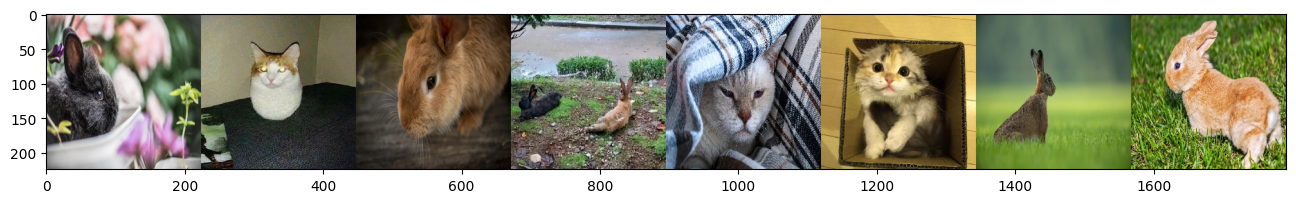

In [13]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Tranfer Learning from Keras VGG16 trained with ImageNet Dataset


In [14]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Create a new classification layer

In [15]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model = Model(inp, out)

freeze weights for all layers except the new classification layer

In [16]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model.layers[-1:]):
    layer.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

training

In [ ]:
history = model.fit(x_train, y_train,
                         batch_size=128,
                         epochs=30,
                         validation_data=(x_val, y_val))

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 227s 78s/step - accuracy: 0.8603 - loss: 0.3760 - val_accuracy: 0.8082 - val_loss: 0.4350
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 222s 77s/step - accuracy: 0.8793 - loss: 0.3504 - val_accuracy: 0.8356 - val_loss: 0.4546
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 260s 77s/step - accuracy: 0.8608 - loss: 0.3678 - val_accuracy: 0.8082 - val_loss: 0.4337
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 260s 75s/step - accuracy: 0.8740 - loss: 0.3444 - val_accuracy: 0.8082 - val_loss: 0.4264
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 265s 76s/step - accuracy: 0.8661 - loss: 0.3553 - val_accuracy: 0.8356 - val_loss: 0.4420
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 265s 77s/step - accuracy: 0.8661 - loss: 0.3437 - val_accuracy: 0.8082 - val_loss: 0.4278
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 259s 77s/step - accuracy: 0.8774 - loss: 0.3352 - val_accuracy: 0.8082 - val_loss: 0.4207
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 220s 76s/step - accuracy: 0.8896 - loss: 0.3298 - val_accuracy: 0.8356 - val_loss:

Plot validation loss/accuracy

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Novamente, fazemos uma validação final no conjunto de testes.

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Para prever uma nova imagem, basta executar o código a seguir para obter as probabilidades de cada classe.

In [ ]:
image_path = 'Dataset-bunny_cat/classes/bunny/101.jpg'
img, x = get_image(image_path)
# Exibir a imagem
plt.imshow(img)
plt.title("Imagem de Teste")
plt.axis('off') # Remove os eixos
plt.show()

In [ ]:
# O 'model' aqui é a sua rede já treinada e model_new a rede treinada com transferlearning
# Certifique-se de que o modelo foi carregado e treinado antes de executar esta célula.
probabilities = model.predict([x])
# Para exibir as probabilidades
print("Probabilidades de classificação:", probabilities)
# Encontrar a classe com a maior probabilidade
predicted_class_index = np.argmax(probabilities[0])
# Se as suas categorias forem 'bunny' e 'cat'
class_labels = ['bunny', 'cat']
predicted_class = class_labels[predicted_class_index]

print(f"A imagem foi classificada como: {predicted_class}")
print(f"Com probabilidade de: {probabilities[0][predicted_class_index]:.2f}")